In [1]:
#%conda info -e
#%pip install yfinance
#%conda env export > requirements.yml
#!explorer .00

#%pip install stocktrends
#%conda activate tensorflow_1.15
%conda info -e
#%pip install yfinance
#%pip install pandas-datareader
#%pip install -U scikit-learn

# conda environments:
#
base                     C:\ProgramData\Anaconda3
tensorflow1              C:\ProgramData\Anaconda3\envs\tensorflow1
wordcount                C:\ProgramData\Anaconda3\envs\wordcount
fortran                  C:\Users\salmasi\.conda\envs\fortran
tensorflow2           *  C:\Users\salmasi\.conda\envs\tensorflow2
tensorflow_1.15          C:\Users\salmasi\.conda\envs\tensorflow_1.15


Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy as scp
from math import erf
import yfinance as yf
import collections
from pandas_datareader import data as pdr
import numpy as np
from sklearn.preprocessing import scale
#from TFANN import ANNR
import pandas as pd
import json
from datetime import date
#from stocktrends import Renko
from itertools import cycle, islice
from sklearn.preprocessing import MinMaxScaler
#tf.enable_eager_execution()
import mplfinance as mpf


C:\Users\salmasi\.conda\envs\tensorflow2\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [14]:
def plot(path,lim1=-2,lim2=-1,means=(10,1),name="stock",frmaesize=(10,6),show_nonetrading=True,show_volume=True):
    data = pd.read_csv(path,index_col=0,parse_dates=True)
    daily=data[lim1:lim2]
    daily.index.name = 'Date'
    daily.shape
    mpf.plot(daily,type='candle',mav=means,volume=show_volume,show_nontrading=show_nonetrading,figsize=frmaesize)   

In [18]:
tickers=["aapl","ibm","googl"]
today=str(date.today())
startdate="2020-01-01"
# dictionary of dataframes kes=tickers
dfs={}
json_export={}
yf.pdr_override() 
for ticker in tickers:
    dfs[ticker]=(pdr.get_data_yahoo(ticker, start=startdate, end=today))
    dfs[ticker].to_csv(ticker+".csv")


for ticker in tickers:
    dfs[ticker]=pd.read_csv(ticker+".csv",index_col=0,parse_dates=True)
    #dfs[ticker].rename(columns={'Adj Close':'Adj_Close'}, inplace=True)
    #dfs[ticker].rename(columns=str.lower, inplace=True)
    #dfs[ticker]['intiger_index']=np.arange(1,len(dfs[ticker])+1)
    #dfs[ticker]['timestamp_index']=dfs[ticker].index

    
    
# multi feature concatination of all daraframes to one dataframe
dfs_concat=dfs[tickers[0]]
for ticker in tickers[1:]:
    dfs_concat = pd.concat([dfs_concat,dfs[ticker]])
dfs_concat.to_csv('alldata.csv')
print('datatypes: \n', dfs_concat.dtypes,"\n", "indexes: \n", dfs_concat.index,"\n", "columns: \n", dfs_concat.keys())
plt.figure()




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
datatypes: 
 Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object 
 indexes: 
 DatetimeIndex(['2019-12-31', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2020-06-04', '2020-06-05', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-15',
               '2020-06-16', '2020-06-17'],
              dtype='datetime64[ns]', name='Date', length=351, freq=None) 
 columns: 
 Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
'''todo: write to file'''


'todo: write to file'

# Plot

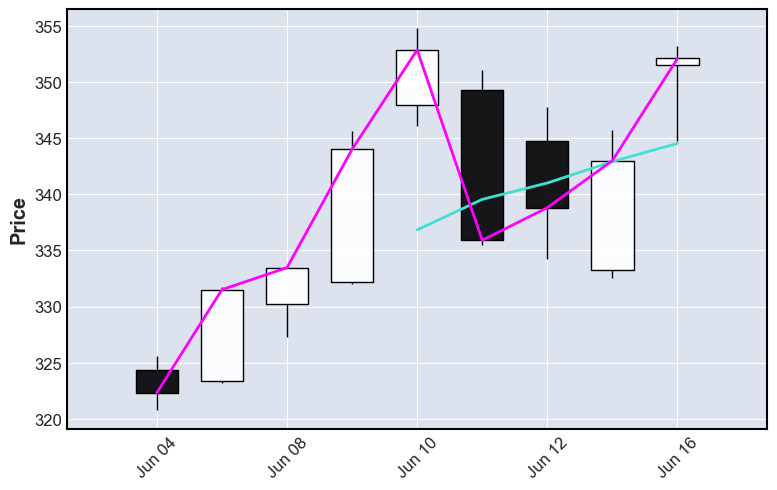

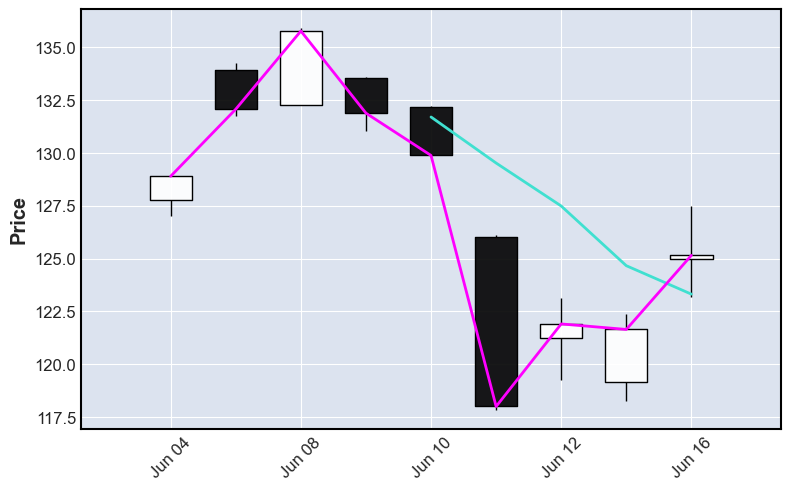

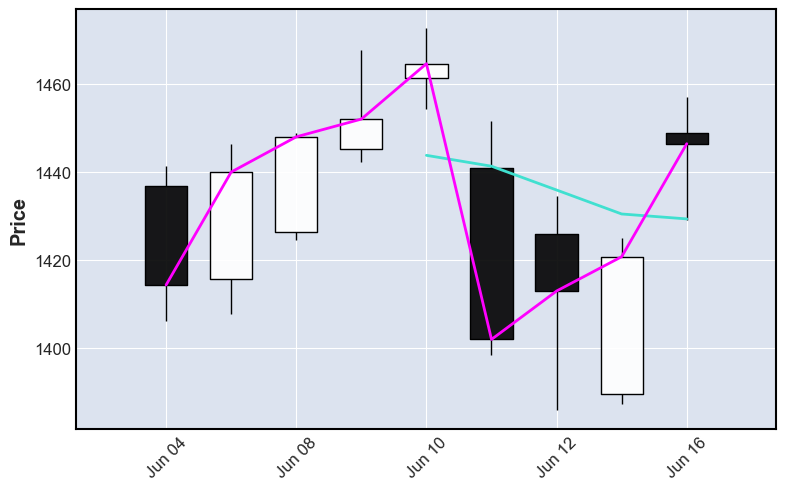

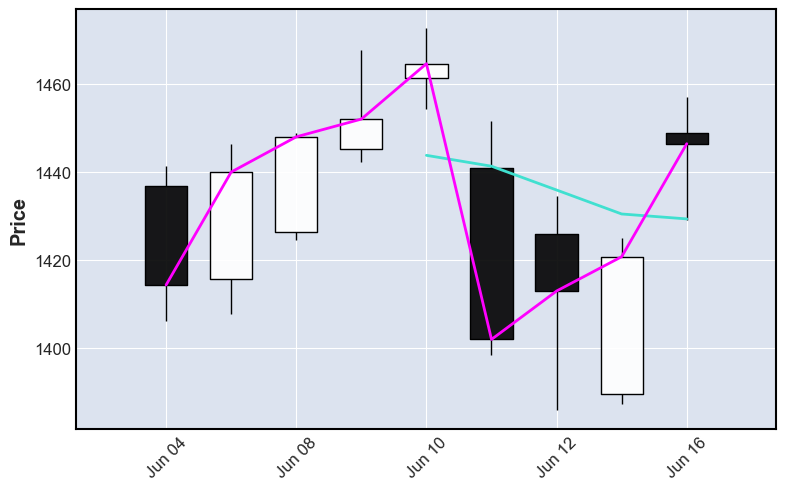

In [22]:
lim1=-10
lim2=-1
means=(5,1)
for ticker in tickers:
    plot(ticker+".csv",lim1,lim2,means,ticker,frmaesize=(10,6),show_nonetrading=False,show_volume=False)
plot("alldata.csv",lim1,lim2,means,ticker,frmaesize=(10,6),show_nonetrading=False,show_volume=False)

Features: [0.1363465  0.13673412 0.13909201 0.1390672  0.22909438], Target: 0.13878324860066965


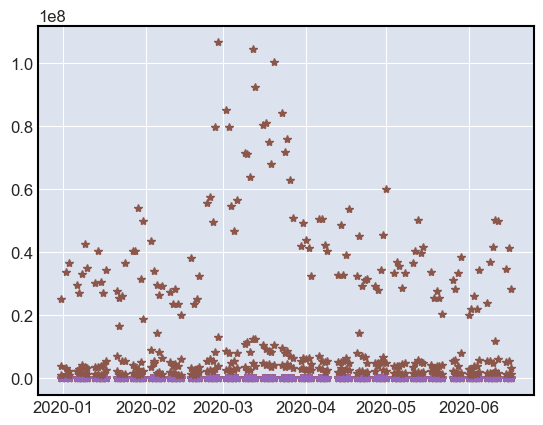

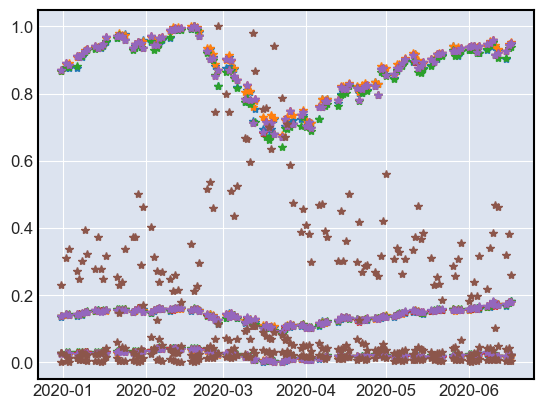

In [23]:
scaler = MinMaxScaler()
plt.figure()
plt.plot(dfs_concat,'*')

dfs_concat_scaled_matrix=scaler.fit_transform(dfs_concat.values)
dfs_concat_scaled_dataframe = pd.DataFrame(dfs_concat_scaled_matrix, index=dfs_concat.index, columns=dfs_concat.columns)

plt.figure()
plt.plot(dfs_concat_scaled_dataframe,'*')
#tf.disable_eager_execution()


target = dfs_concat_scaled_dataframe.pop('Adj Close')

#train, test = train_test_split(dfs_concat_scaled_dataframe, test_size=0.2)
#print(train)

dataset = tf.data.Dataset.from_tensor_slices((dfs_concat_scaled_dataframe.values, target.values))

for feat,targ in dataset.take(1):
    print ('Features: {}, Target: {}'.format(feat, targ))

train_dataset = dataset.shuffle(len(dfs_concat_scaled_dataframe)).batch(1)






In [24]:
totalDays = dfs_concat_scaled_dataframe.shape[0]
holdDays = 5

In [25]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

model = get_compiled_model()
model.fit(train_dataset, epochs=15)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Dense(7891*6),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10)
# ])


Epoch 1/15

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

351/351 [==============================] - 0s 690us/step - loss: 0.5854 - accuracy: 0.0028
Epoch 2/15
351/351 [==============================] - 0s 781us/step - loss: 0.3318 - accuracy: 0.0057
Epoch 3/15
351/351 [==============================] - 0s 674us/step - loss: 0.3098 - accuracy: 0.0057
Epoch 4/15
351/351 [==============================] - 0s 710us/step - loss: 0.2981 - accuracy: 0.0057
Epoch 5/15
351/351 [==============================] - 0s 656us/step - loss: 0.2902 - accuracy: 0.005

In [32]:
predictions = model.predict(dfs_concat_scaled_dataframe[-1000:-1])
predictions


array([[-1.8468927 ],
       [-1.7464722 ],
       [-1.7237772 ],
       [-1.7861527 ],
       [-1.8045645 ],
       [-1.7411363 ],
       [-1.6365668 ],
       [-1.6938554 ],
       [-1.7204024 ],
       [-1.6302034 ],
       [-1.7257739 ],
       [-1.7531406 ],
       [-1.6787277 ],
       [-1.737994  ],
       [-1.7544445 ],
       [-1.7491591 ],
       [-1.6447272 ],
       [-1.6493263 ],
       [-1.626374  ],
       [-1.4750639 ],
       [-1.6844591 ],
       [-1.5295774 ],
       [-1.6179214 ],
       [-1.6782292 ],
       [-1.6998185 ],
       [-1.7273343 ],
       [-1.7071289 ],
       [-1.7316345 ],
       [-1.7570174 ],
       [-1.7026598 ],
       [-1.7483424 ],
       [-1.7810135 ],
       [-1.643092  ],
       [-1.7556684 ],
       [-1.7407205 ],
       [-1.6911474 ],
       [-1.601844  ],
       [-1.6478633 ],
       [-1.6837794 ],
       [-1.8325262 ],
       [-1.8907688 ],
       [-1.6244605 ],
       [-1.6169957 ],
       [-1.5887973 ],
       [-1.6594353 ],
       [-1

In [ ]:
print((predictions.shape))

In [ ]:
# holdDays = 5
# totalDays = dfs_concat_scaled_dataframe.shape[0]
# #mlpr.fit(dfs_concat_scaled_dataframe.index[0:(totalDays-holdDays)].T, dfs_concat_scaled_dataframe['Adj Close'][0:(totalDays-holdDays)])
# mlpr.fit(a, dfs_concat_scaled_dataframe['Adj Close'][0:(totalDays-holdDays)])

In [ ]:
# #Predict the stock price using the model
# pricePredict = mlpr.predict(date_idx)
# #Display the predicted reuslts agains the actual data
# plt.plot(date_idx, adj_close_price)
# plt.plot(date_idx, pricePredict, c='#5aa9ab')
# plt.show()

In [ ]:
# #Number of neurons in the input, output, and hidden layers
# input2 = 1
# output2 = 1
# hidden2 = 50
# #array of layers, 3 hidden and 1 output, along with the tanh activation function 
# layers = [('F', hidden2), ('AF', 'tanh'), ('F', hidden2), ('AF', 'tanh'), ('F', hidden2), ('AF', 'tanh'), ('F', output2)]
# #construct the model and dictate params
# mlpr2 = ANNR([input2], layers, batchSize = 256, maxIter = 10000, tol = 0.01, reg = 1e-4, verbose = True)

In [ ]:
# holdDays = 5
# totalDays = len(date_idx)
# mlpr2.fit(date_idx[0:(totalDays-holdDays)], adj_close_price[0:(totalDays-holdDays)])
# pricePredict2 = mlpr2.predict(date_idx)

In [ ]:
# plt.plot(date_idx, adj_close_price)
# plt.plot(date_idx, pricePredict, c='#5aa9ab')
# plt.plot(date_idx, pricePredict2, c='#8B008B')
# plt.show()

In [ ]:
# pricePredict3 = mlpr2.predict(date_idx[-holdDays:])
# print((pricePredict3-date_idx[-holdDays:])/date_idx[-holdDays:]*100)